# Impact of clustering on classification results, and stats

The purpose of this notebook is to observe how the data responds to being clustered by cd-hit at different thresholds.

In a second step, we perform deterministic randomized undersampling, to determine the smallest number of samples that leads to good classification results.

Then, we undersample the majority class, to test whether that makes its score approach that of the minority class.

Finally, we recreated some of the plots from Notebook 2, after a 70% cluster threshold has been applied.

## Imports

In [79]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
    downsampling_plot, downsample_majority_class_plot
)
from subpred.cdhit import cd_hit
from subpred.util import perform_pca, get_protein_feature_stats
import seaborn as sns

In [57]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [559292],
    output_log = "../logs/yeast_amino_sugar_dataset.log",
)

In [58]:
df_stats_long = get_clustering_stats(df)
df_stats_long

,identity_threshold,kw_type,keyword,count
0,40,keywords_location,Cell membrane,3
1,40,keywords_location,Endoplasmic reticulum,6
2,40,keywords_location,Membrane,36
3,40,keywords_location,Mitochondrion,2
4,40,keywords_location,Transmembrane,36
...,...,...,...,...
72,100,keywords_transport,Sugar transport,28
73,100,keywords_transport_related,Symport,1
74,100,keywords_transport_related,Transport,64
75,100,tcdb_class,0.0,9


In [59]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

The number of transporter drops much more sharply than in the other organisms. For sugar, the number of transporters reaches below a critically low level even at 90% clustering. Only 17 transporters remain at threshold 17. We should compare LOOCV to 5-fold CV, and test the removal of potential outliers, such as polysaccharide transporters or vacuolar amino acid transporters.

keyword,Amino-acid transport,Sugar transport
identity_threshold,,
40,25,11
50,29,11
60,31,13
70,34,17
80,36,22
90,36,24
100,36,28


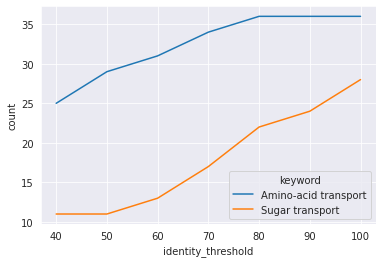

In [60]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

The number of proteins that are annotated with a specific membrane is generally relatively low in yeast, so this table does not say much:

keyword,Cell membrane,Endoplasmic reticulum,Membrane,Mitochondrion,Transmembrane
identity_threshold,,,,,
40,3,6,36,2,36
50,4,7,40,2,40
60,5,7,44,3,44
70,9,7,51,3,51
80,10,8,58,3,58
90,10,8,60,3,60
100,11,8,64,3,64


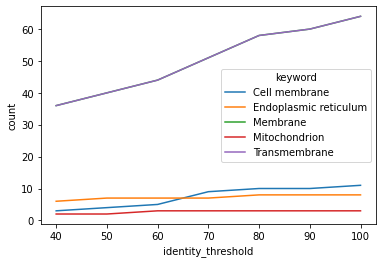

In [7]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

Transport systems:

The symporters stays in the dataset, even at 40%.

keyword,Symport,Transport
identity_threshold,,
40,1,36
50,1,40
60,1,44
70,1,51
80,1,58
90,1,60
100,1,64


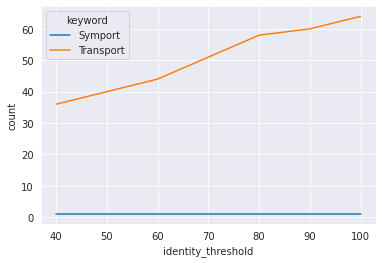

In [61]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

At a 70% threshold, only four non-annotated transporters are left. This could be because several non-TCDB transporters were in the HXT family.

keyword,0.0,2.A
identity_threshold,,
40,2,34
50,2,38
60,3,41
70,4,47
80,6,52
90,8,52
100,9,55


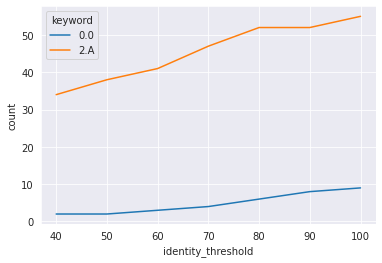

In [62]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

The performance of sugar is already lower at the start, possibly because <30 samples are available even at the start.

(0.0, 1.0)

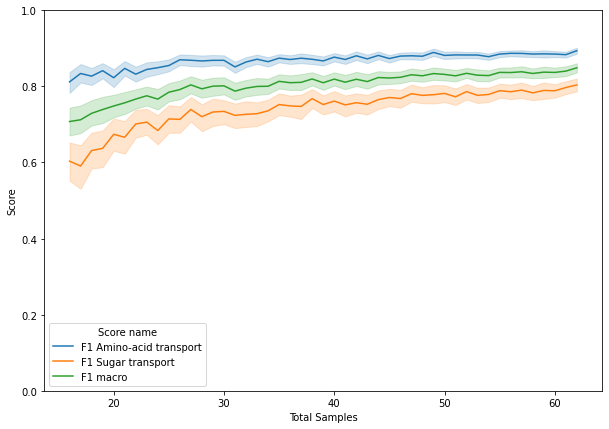

In [16]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

g = downsampling_plot(df_aac, labels)
g.set_ylim((0,1))

The paac delivers similar results, without feature selection:

(0.0, 1.0)

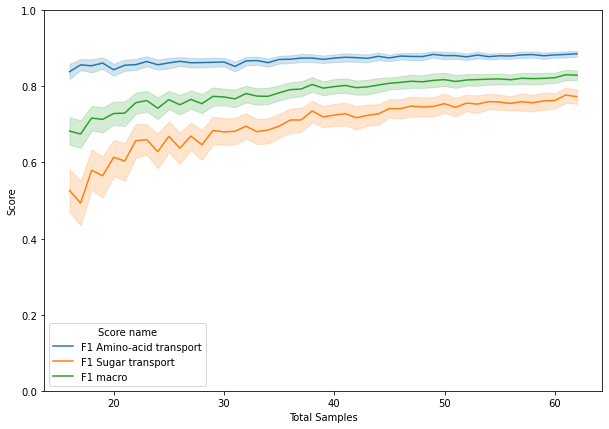

In [15]:
df_paac = calculate_paac(df.sequence)
import matplotlib.pyplot as plt
g = downsampling_plot(df_paac, labels)
g.set_ylim((0,1))

When downsampling the majority class until the dataset is balanced, the performance of amino-acid transports becomes lower, but does not reach that of sugar transporters.

(0.0, 1.0)

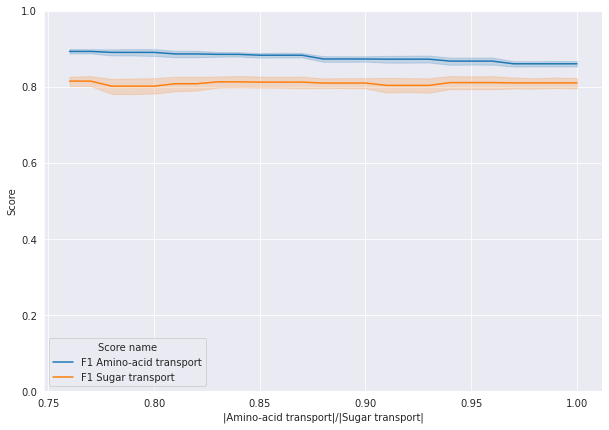

In [48]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
g = downsample_majority_class_plot(
    df_aac,
    labels,
    n_jobs=-1,
    min_class_sample_fractions=[x / 100 for x in range(76, 101)],
    include_macro=False,
)
g.set_ylim((0,1))

With PAAC, the sugar score even becomes a bit better. This could be caused by the removal of proteins from the mixed cluster (see notebook 3)

(0.0, 1.0)

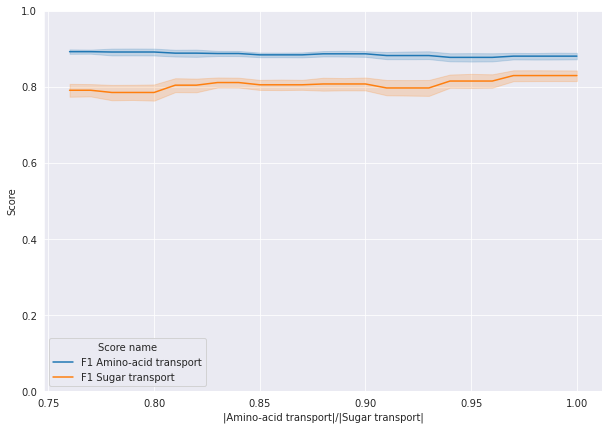

In [49]:
df_paac = calculate_paac(df.sequence)
labels = df.keywords_transport.rename("labels")
g = downsample_majority_class_plot(
    df_paac,
    labels,
    n_jobs=-1,
    min_class_sample_fractions=[x / 100 for x in range(76, 101)],
    include_macro=False,
)
g.set_ylim((0,1))

## Plots at 70% cluster threshold


13 proteins are removed at 70% clustering threshold

In [30]:
cluster_representatives_70 = cd_hit(df.sequence, identity_threshold=70)
df_clustered = df.loc[cluster_representatives_70]

cd-hit: clustered 64 sequences into 51 clusters at threshold 70


In [63]:
df_aac_clustered = calculate_aac(df_clustered.sequence)
df_paac_clustered = calculate_paac(df_clustered.sequence)
labels_clustered = df_clustered.keywords_transport.rename("labels")

### Feature importance


The four most important amino acids stay the same, just their order changes:

Text(0.5, 1.0, 'No clustering')

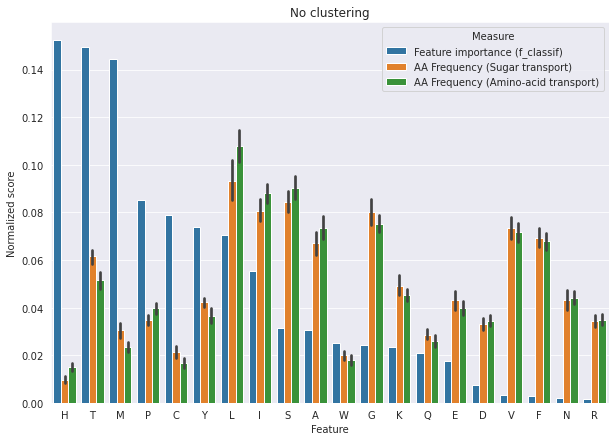

In [66]:
g = feature_importance_plot(df_aac, labels, method="f_classif")

g.set_title("No clustering")

Text(0.5, 1.0, '70% clustering')

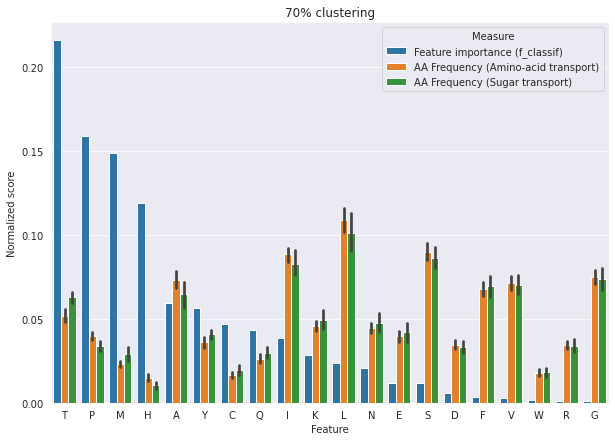

In [69]:
g = feature_importance_plot(df_aac_clustered, labels_clustered, method="f_classif")

g.set_title("70% clustering")

### PCA



#### AAC

The PCA of the AAC looks similar, but is rotated a bit to the right:

Text(0.5, 1.0, 'No Clustering')

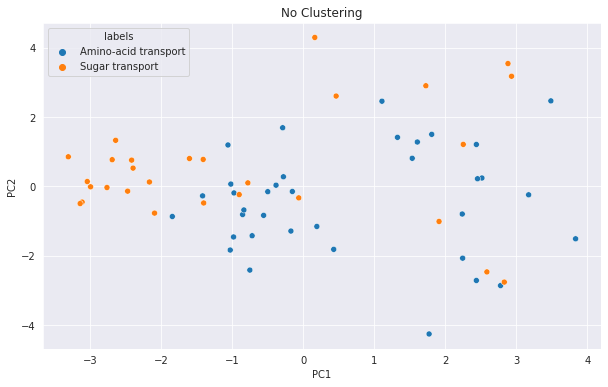

In [72]:
g = pca_plot_2d(df_aac.loc[labels.sort_values().index], labels.loc[labels.sort_values().index])
g.set_title("No Clustering")

Text(0.5, 1.0, '70% clustering')

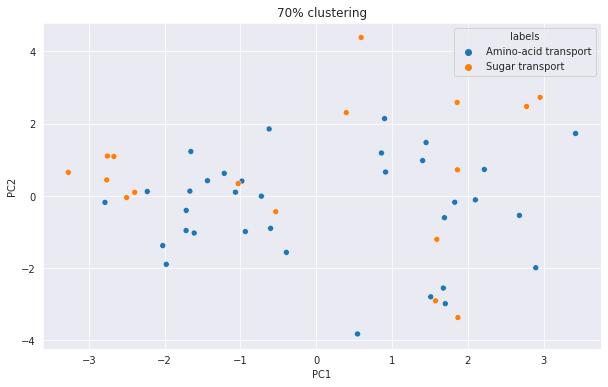

In [73]:
g = pca_plot_2d(df_aac_clustered, labels_clustered)
g.set_title("70% clustering")

#### PAAC

The PCA of the PAAC is rotated about 45 degrees to the left and mirrored, which is caused by the removal of some of the HXT proteins in the cluster on the right:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

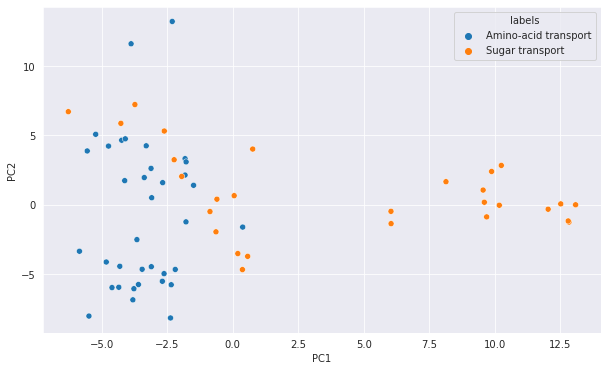

In [37]:
order_labels = labels.sort_values().index
pca_plot_2d(df_paac.loc[order_labels], labels.loc[order_labels])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

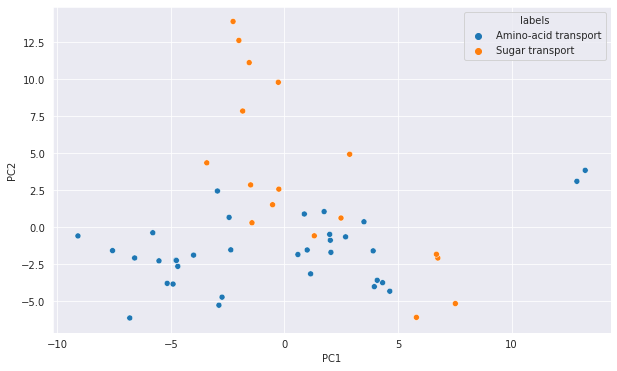

In [34]:
pca_plot_2d(df_paac_clustered, labels_clustered)

The HXT proteins still form a cluster, but not as clearly as before:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

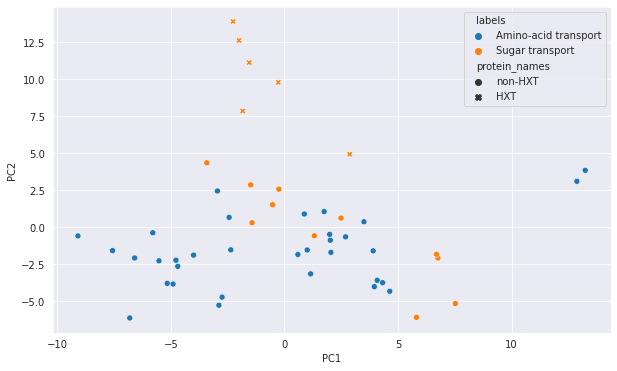

In [38]:
pca_plot_2d(df_paac_clustered, labels_clustered, df.protein_names.transform(lambda x: "HXT" if "HXT" in x else "non-HXT"))

What are the two AA transporters o the right?

In [77]:
df.loc[perform_pca(df_paac_clustered, labels_clustered).query("PC1 > 10").index]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q12010,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ1 YOL092W O0929,Probable vacuolar amino acid transporter YPQ1 ...,2.A.43.2.3,2.A,559292,MQLVPLELNRSTLSGISGSISISCWIIVFVPQIYENFYRKSSDGLS...
P38279,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,RTC2 YPQ3 YBR147W YBR1124,Probable vacuolar amino acid transporter YPQ3 ...,2.A.43.2.7,2.A,559292,MKLIPIILNAKNLSGMAGSISICCWIVVFVPQIYENFRRQSAEGLS...


The Yeast PQ-loop protein, and its paralog RTC2 that arose from whole genome duplication. They have two "PQ domains", which could be the source of their different PAAC after PCA.

They also are vascuolar transporters, and are closer to other vascuolar transporters than non-vascuolar:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

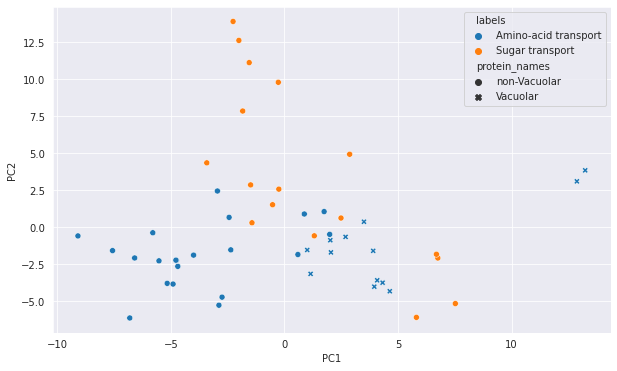

In [40]:
pca_plot_2d(
    df_paac_clustered,
    labels_clustered,
    df.protein_names.transform(
        lambda x: "Vacuolar" if "vacuol" in x.lower() else "non-Vacuolar"
    ),
)

Besides the two HXT proteins, there is nothing that sets the non-TCDB transporters apart:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

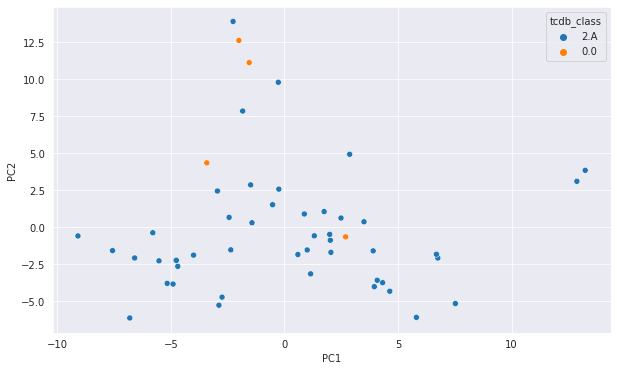

In [41]:
pca_plot_2d(df_paac_clustered, df.tcdb_class)

Nothing notable to say about the symporter in the PCA:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

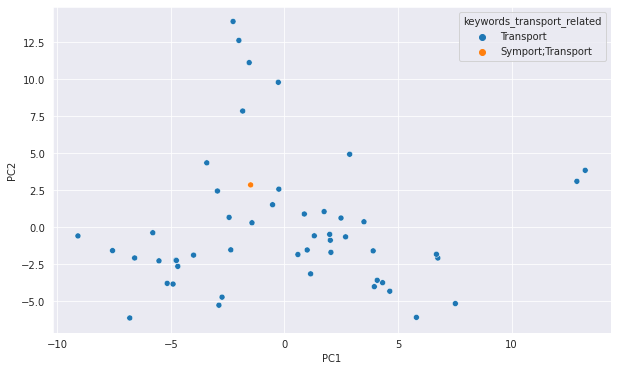

In [42]:
pca_plot_2d(df_paac_clustered, df.keywords_transport_related)

## Clustering heatmaps

##### Before clustering

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f4f93efcd00>)

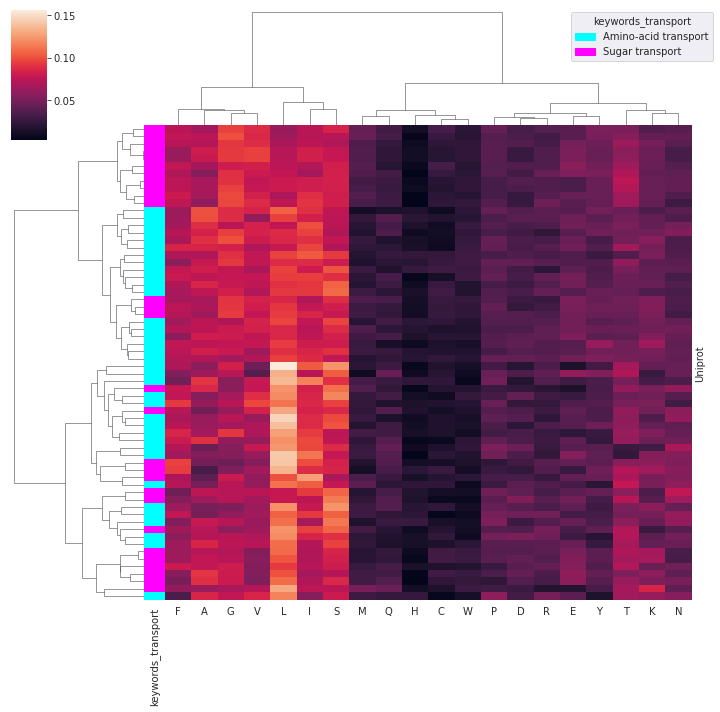

In [83]:
labeled_clustermap(df_aac, df.keywords_transport, xlabels="auto")

##### After clustering

The cluster of monosaccharide transporters at the top becomes a lot smaller after clustering:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f52812b7940>)

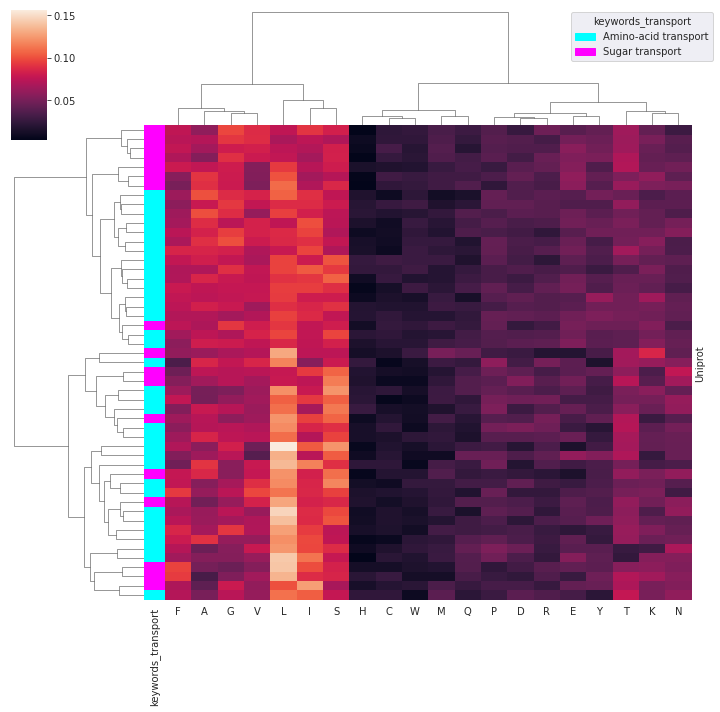

In [43]:
labeled_clustermap(df_aac_clustered, df_clustered.keywords_transport, xlabels="auto")

In [88]:
sugars = (
    df[df.keywords_transport.str.startswith("Sugar")]
    .protein_names.apply(
        lambda x: [y.replace("(", "").lower() for y in x.split() if y.endswith("ose")]
    )
    .apply(lambda x: x[0] if x else "Other")
)
sugars.value_counts()


hexose           9
glucose          7
Other            5
maltose          4
galactose        1
gdp-mannose      1
udp-galactose    1
Name: protein_names, dtype: int64

In [87]:
sugars = (
    df_clustered[df_clustered.keywords_transport.str.startswith("Sugar")]
    .protein_names.apply(
        lambda x: [y.replace("(", "").lower() for y in x.split() if y.endswith("ose")]
    )
    .apply(lambda x: x[0] if x else "Other")
)
sugars.value_counts()


Other            5
glucose          4
hexose           4
maltose          2
gdp-mannose      1
udp-galactose    1
Name: protein_names, dtype: int64

This is also reflected in the stats. Ater clustering, the largest group is "other sugars", not hexose and glucose.


The same is true for paac:

AttributeError: 'ClusterGrid' object has no attribute 'set_title'

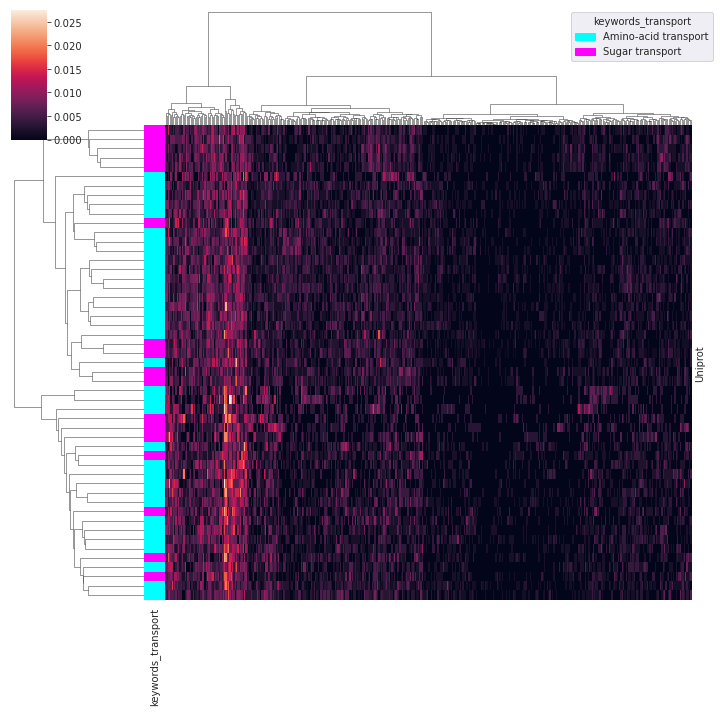

In [94]:
# After clustering
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport)

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f52612ecd00>)

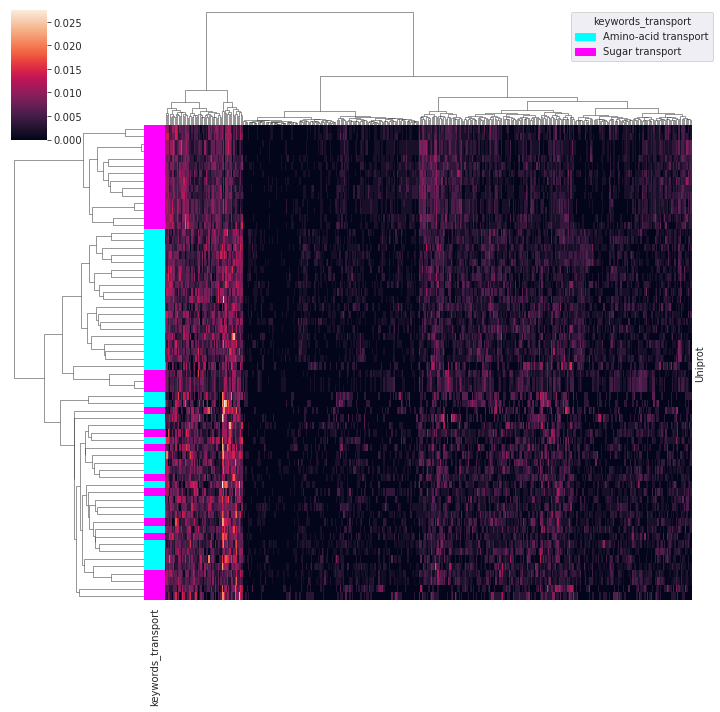

In [95]:
# Before clustering
labeled_clustermap(df_paac, df.keywords_transport)